In [ ]:
# CELL F
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np, glob, os, json

#computing split-half from timeseries
ts_files = sorted(glob.glob(os.path.join(TS_DIR,'*_ts.npy')))
subjects = []
first_vecs = []
second_vecs = []

for t in ts_files:
    base = os.path.basename(t).replace('_ts.npy','')
    subj = base.split('_')[0]
    ts = np.load(t)
    T = ts.shape[0]
    if T < 20:
        continue
    half = T//2
    ts1 = ts[:half,:].astype(np.float32)
    ts2 = ts[half:,:].astype(np.float32)
    C1 = np.corrcoef(ts1.T); np.fill_diagonal(C1,1.0); C1 = np.clip(C1,-0.999999,0.999999); Z1 = np.arctanh(C1)
    C2 = np.corrcoef(ts2.T); np.fill_diagonal(C2,1.0); C2 = np.clip(C2,-0.999999,0.999999); Z2 = np.arctanh(C2)
    v1 = upper_tri_vec_from_mat(Z1)
    v2 = upper_tri_vec_from_mat(Z2)
    subjects.append(subj)
    first_vecs.append(v1)
    second_vecs.append(v2)

first_vecs = np.vstack(first_vecs)
second_vecs = np.vstack(second_vecs)
print("Prepared vectors for", len(subjects), "subjects. Feature dim:", first_vecs.shape[1])

sim = cosine_similarity(first_vecs, second_vecs)
preds = sim.argmax(axis=1)
accuracy = (preds == np.arange(len(subjects))).mean()
print(f"Split-half fingerprint accuracy: {accuracy:.3f} ({int(accuracy*100)}%)")

# Save sim and results
np.save(os.path.join(RESULTS_DIR,'split_half_similarity.npy'), sim)
with open(os.path.join(RESULTS_DIR,'split_half_results.json'),'w') as f:
    json.dump({'accuracy': float(accuracy), 'n_subjects': len(subjects), 'subjects': subjects}, f, indent=2)
print("Saved fingerprint results to", RESULTS_DIR)


Prepared vectors for 30 subjects. Feature dim: 19900
Split-half fingerprint accuracy: 1.000 (100%)
Saved fingerprint results to /content/drive/MyDrive/fmri_fingerprint/results


In [ ]:
# CELL G
import numpy as np, time
from sklearn.metrics.pairwise import cosine_similarity
rng = np.random.RandomState(123)
n_perm = 500
t0 = time.time()
perm_accs = []
for i in range(n_perm):
    perm_idx = rng.permutation(second_vecs.shape[0])
    sim_perm = cosine_similarity(first_vecs, second_vecs[perm_idx])
    preds_perm = sim_perm.argmax(axis=1)
    acc_perm = (preds_perm == np.arange(len(subjects))).mean()
    perm_accs.append(acc_perm)
pval = (np.sum(np.array(perm_accs) >= accuracy) + 1) / (n_perm + 1)
t1 = time.time()
print(f"Permutation p-value (n={n_perm}): {pval:.4f} (time {t1-t0:.1f}s)")
np.save(os.path.join(RESULTS_DIR,'perm_accs.npy'), np.array(perm_accs))
with open(os.path.join(RESULTS_DIR,'perm_test.json'),'w') as f:
    json.dump({'n_perm': n_perm, 'pval': float(pval), 'observed_acc': float(accuracy)}, f, indent=2)


Permutation p-value (n=500): 0.0020 (time 4.9s)


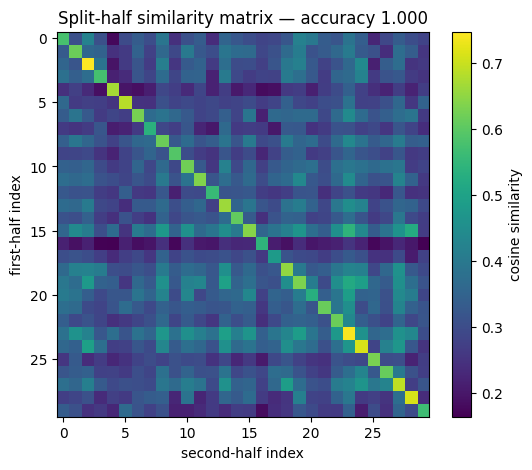

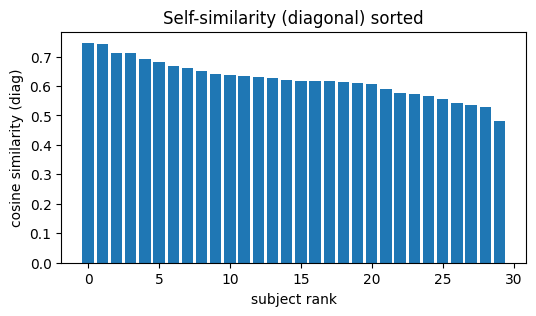

Saved figures to: /content/drive/MyDrive/fmri_fingerprint/results/sim_heatmap.png /content/drive/MyDrive/fmri_fingerprint/results/diag_sorted.png


In [ ]:
# CELL H
import matplotlib.pyplot as plt, numpy as np, os
sim = np.load(os.path.join(RESULTS_DIR,'split_half_similarity.npy'))
acc = float(np.load(os.path.join(RESULTS_DIR,'split_half_results.json'), allow_pickle=True).tolist()['accuracy']) if False else accuracy

plt.figure(figsize=(6,5))
plt.imshow(sim, aspect='auto', cmap='viridis')
plt.colorbar(label='cosine similarity')
plt.title(f'Split-half similarity matrix — accuracy {acc:.3f}')
plt.xlabel('second-half index')
plt.ylabel('first-half index')
fig1 = os.path.join(RESULTS_DIR,'sim_heatmap.png')
plt.savefig(fig1, dpi=150, bbox_inches='tight')
plt.show()

diag = np.diag(sim)
order = np.argsort(diag)[::-1]
plt.figure(figsize=(6,3))
plt.bar(range(len(diag)), diag[order])
plt.title('Self-similarity (diagonal) sorted')
plt.xlabel('subject rank')
plt.ylabel('cosine similarity (diag)')
fig2 = os.path.join(RESULTS_DIR,'diag_sorted.png')
plt.savefig(fig2, dpi=150, bbox_inches='tight')
plt.show()

print("Saved figures to:", fig1, fig2)


In [ ]:
# CELL I
import zipfile, glob, os
zip_path = os.path.join(WORKDIR, 'fmri_fingerprint_results.zip')
with zipfile.ZipFile(zip_path, 'w', compression=zipfile.ZIP_DEFLATED) as zf:
    if os.path.exists(MANIFEST):
        zf.write(MANIFEST, arcname=os.path.basename(MANIFEST))

    for f in glob.glob(os.path.join(RESULTS_DIR,'*')):
        zf.write(f, arcname=os.path.join('results', os.path.basename(f)))
    # add up to first 30 connectivity files
    npz_files = sorted(glob.glob(os.path.join(CONN_DIR,'*.npz')))
    for f in npz_files[:30]:
        zf.write(f, arcname=os.path.join('connectivity', os.path.basename(f)))
print("Created zip:", zip_path)

from google.colab import files
files.download(zip_path)


Created zip: /content/drive/MyDrive/fmri_fingerprint/fmri_fingerprint_results.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# CELL 1: setup and discover timeseries
import os, glob, numpy as np
WORKDIR = '/content/drive/MyDrive/fmri_fingerprint'
TS_DIR = os.path.join(WORKDIR, 'timeseries')
CONN_DIR = os.path.join(WORKDIR, 'connectivity')
RESULTS_DIR = os.path.join(WORKDIR, 'results')
os.makedirs(RESULTS_DIR, exist_ok=True)


ts_files = sorted(glob.glob(os.path.join(TS_DIR, '*_ts.npy')))
print("Timeseries files found:", len(ts_files))

npz_files = sorted(glob.glob(os.path.join(CONN_DIR, '*.npz')))
print("Connectivity .npz found:", len(npz_files))

if len(ts_files) == 0 and len(npz_files) == 0:
    raise SystemExit("No timeseries or connectivity files found. Run the earlier extraction cells first.")


Timeseries files found: 30
Connectivity .npz found: 30


In [ ]:
# CELL 2: compute split-half Fisher-Z connectomes from timeseries (preferred)
import numpy as np
from math import floor

def compute_z_from_ts(ts):
    C = np.corrcoef(ts.T)
    np.fill_diagonal(C, 1.0)
    C = np.clip(C, -0.999999, 0.999999)
    return np.arctanh(C)

subs = []
Z1_list = []
Z2_list = []

for tpath in ts_files:
    subj = os.path.basename(tpath).replace('_ts.npy','')
    ts = np.load(tpath)  # T x P
    T = ts.shape[0]
    if T < 10:
        print("Skipping short run:", subj, "T=", T)
        continue
    half = T // 2
    ts1 = ts[:half, :]
    ts2 = ts[half:, :]
    Z1 = compute_z_from_ts(ts1)
    Z2 = compute_z_from_ts(ts2)
    subs.append(subj)
    Z1_list.append(Z1)
    Z2_list.append(Z2)

n_subj = len(subs)
print("Subjects processed for split-half ICC:", n_subj)
P = Z1_list[0].shape[0]
print("Parcels (P):", P)
#arrays: shape (n_subj, P, P)
Z1_arr = np.stack(Z1_list, axis=0)
Z2_arr = np.stack(Z2_list, axis=0)


Subjects processed for split-half ICC: 30
Parcels (P): 200


In [ ]:
# CELL 3: ICC across subjects for each edge using the two measurements (Z1 and Z2)
import numpy as np


iu = np.triu_indices(P, k=1)
n_edges = len(iu[0])
print("Number of edges:", n_edges)


edge_vals_1 = Z1_arr[:, iu[0], iu[1]]
edge_vals_2 = Z2_arr[:, iu[0], iu[1]]

def compute_icc_for_edge(x1, x2):
    # x1, x2 are arrays shape (n_subj,)
    X = np.vstack([x1, x2]).T  # n_subj x 2
    n, k = X.shape
    # subject means
    subj_means = X.mean(axis=1)
    grand_mean = X.mean()
    # MS_between (MSB) = k * sum((subj_mean - grand_mean)^2) / (n - 1)
    MSB = k * np.sum((subj_means - grand_mean)**2) / (n - 1) if n > 1 else 0.0
    # MS_within (MSW) = sum_i sum_j (x_ij - subj_mean_i)^2 / (n*(k-1))
    MSW = np.sum((X - subj_means[:, None])**2) / (n * (k - 1)) if k > 1 else 0.0
    # ICC(1,1) approx (for k=2): (MSB - MSW) / (MSB + (k-1)*MSW)
    denom = (MSB + (k - 1) * MSW)
    if denom == 0:
        return 0.0
    return float((MSB - MSW) / denom)

#efficiently across edges
icc_vals = np.zeros(n_edges, dtype=np.float32)
for e in range(n_edges):
    icc_vals[e] = compute_icc_for_edge(edge_vals_1[:, e], edge_vals_2[:, e])
print("ICC stats — min, median, max:", icc_vals.min(), np.median(icc_vals), icc_vals.max())

# ICC array
np.save(os.path.join(RESULTS_DIR, 'edge_icc_values.npy'), icc_vals)
# P x P ICC matrix
icc_mat = np.zeros((P,P), dtype=np.float32)
icc_mat[iu] = icc_vals
icc_mat = icc_mat + icc_mat.T
np.save(os.path.join(RESULTS_DIR, 'icc_matrix.npy'), icc_mat)
print("Saved ICC arrays to results.")


Number of edges: 19900
ICC stats — min, median, max: -0.36609605 0.4487573 0.8694211
Saved ICC arrays to results.


In [ ]:
# CELL 4: rank edges and top-k list
import numpy as np, pandas as pd
order = np.argsort(icc_vals)[::-1]
topK = 500
top_edges_idx = order[:topK]

top_edges_pairs = [(int(iu[0][e]), int(iu[1][e]), float(icc_vals[e])) for e in top_edges_idx]
df_top = pd.DataFrame(top_edges_pairs, columns=['node_i','node_j','icc'])
df_top.to_csv(os.path.join(RESULTS_DIR, f'top_{topK}_edges_by_icc.csv'), index=False)
print("Saved top edges csv:", os.path.join(RESULTS_DIR, f'top_{topK}_edges_by_icc.csv'))
df_top.head(10)


Saved top edges csv: /content/drive/MyDrive/fmri_fingerprint/results/top_500_edges_by_icc.csv


,node_i,node_j,icc
0,105,111,0.869421
1,31,80,0.863886
2,55,158,0.860467
3,8,105,0.855051
4,102,105,0.847862
5,62,136,0.846499
6,137,165,0.845561
7,8,107,0.844532
8,18,49,0.840399
9,119,164,0.840219


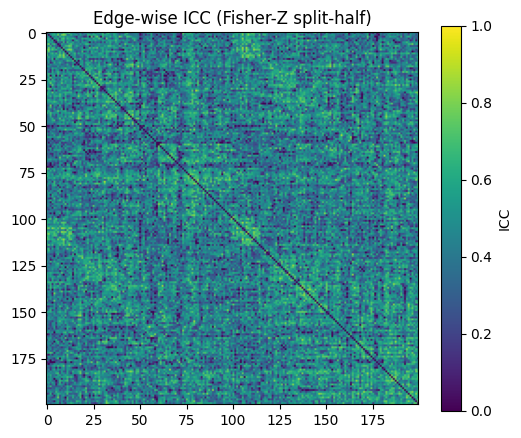

[fetch_atlas_schaefer_2018] Dataset found in /content/drive/MyDrive/fmri_fingerprint/schaefer_2018

Saved ICC heatmap and top-edges connectome to results.


In [ ]:
# CELL 5: heatmap + connectome for top edges
import matplotlib.pyplot as plt
from nilearn import plotting, datasets

# heatmap
plt.figure(figsize=(6,5))
plt.imshow(icc_mat, vmin=0, vmax=1, cmap='viridis')
plt.colorbar(label='ICC')
plt.title('Edge-wise ICC (Fisher-Z split-half)')
plt.savefig(os.path.join(RESULTS_DIR,'icc_heatmap.png'), dpi=150, bbox_inches='tight')
plt.show()

# connectome of top edges
# fetch coords for Schaefer atlas (Schaefer-200 used)
atlas = datasets.fetch_atlas_schaefer_2018(n_rois=P, yeo_networks=7, data_dir=WORKDIR)
coords = plotting.find_parcellation_cut_coords(atlas['maps'])

mat_top = np.zeros((P,P))
mat_top[iu] = 0.0
mat_top[iu[0][top_edges_idx], iu[1][top_edges_idx]] = icc_vals[top_edges_idx]
mat_top = mat_top + mat_top.T

display = plotting.plot_connectome(mat_top, coords, node_size=20, title=f'Top {topK} ICC edges')
display.savefig(os.path.join(RESULTS_DIR, f'top_{topK}_icc_connectome.png'))
display.close()
print("Saved ICC heatmap and top-edges connectome to results.")
